# kaggle Titanic over80%
参考にしたページ
https://qiita.com/jun40vn/items/d8a1f71fae680589e05c

https://qiita.com/tani_AI_Academy/items/62151d7e151024733919

In [114]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1
import warnings
# 不要な警告文を表示しない
warnings.filterwarnings("ignore")

In [115]:
pip install pycaret

In [116]:
# ライブラリの読み込み
from pycaret.classification import *
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
# matplotlib日本語化対応
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

# 小数点第３位まで表示
%precision 3

# データ読み込み
test_data = pd.read_csv("/content/drive/My Drive/AI/titanic/test.csv")
train_data = pd.read_csv("/content/drive/My Drive/AI/titanic/train.csv")

# データサイズの確認
print('訓練データサイズ：' + str(train_data.shape))
print('テストデータサイズ：' + str(test_data.shape))

訓練データサイズ：(891, 12)
テストデータサイズ：(418, 11)


### 検証のため、訓練データとテストデータの統合


In [117]:
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)
# 日本語用
df2 = pd.concat([train_data, test_data], ignore_index=True, sort=False)
columns_t = ['乗客ID', '生存', '階級', '名前', '性別', 
             '年齢', '兄弟配偶者数', '両親子供数', 'チケット番号', 
             '乗船料金', '部屋番号', '乗船港']
df2.columns = columns_t
# 性別名を日本語化
df2['性別'].replace('male','男性',inplace=True)
df2['性別'].replace('female','女性',inplace=True)


### 訓練データでの生存率

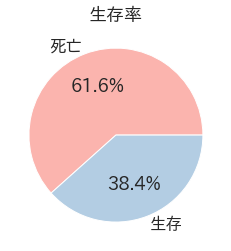

In [118]:
sns.set(style='white',font='IPAexGothic',font_scale=1.5,palette="Pastel1")
plt.pie(df2["生存"].value_counts(),labels=["死亡","生存"],autopct="%.1f%%")
plt.title("生存率")
plt.rcParams["font.size"] = 10

plt.show()

## 性別ごとの生存率

性別
女性    0.742038
男性    0.188908
Name: 生存, dtype: float64


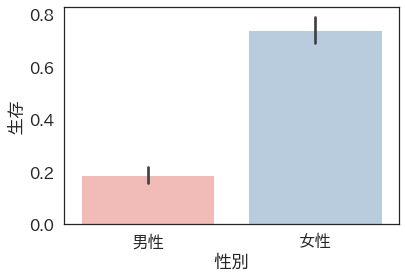

In [119]:
print(df2['生存'].groupby(df2['性別']).mean())
sns.barplot(x='性別', y='生存', data=df2)
plt.rcParams["font.size"] = 18
plt.show()

性別の違いが生存率に大きく関係している

## 欠損値の確認

In [120]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

年齢と、部屋番号の欠損値が多い。また、乗船料金と乗船港においては少数である。

# 年齢の欠損値の推定
年齢の欠損値に入るべき値を階級・性別・両親子供数・兄弟配偶者数を特徴量として、ランダムフォレストで推定

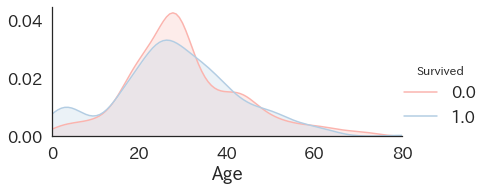

In [121]:
from sklearn.ensemble import RandomForestRegressor

age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

age_df=pd.get_dummies(age_df)

known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

X = known_age[:, 1:]  
y = known_age[:, 0]

rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

### 名前から特徴量設定
名前から敬称を抜き出し、グループ化する。

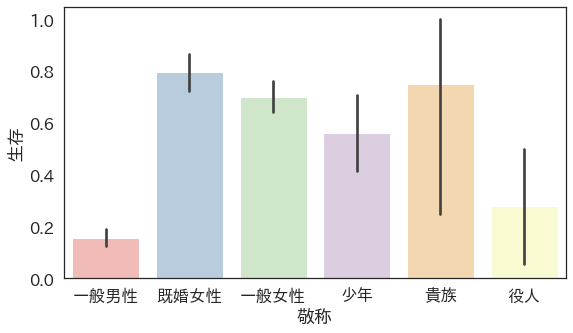

In [122]:
# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)

df2['敬称'] = df2['名前'].map(lambda x: x.split(', ')[1].split('. ')[0])
df2['敬称'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], '役人', inplace=True)
df2['敬称'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], '貴族', inplace=True)
df2['敬称'].replace(['Mme', 'Ms','Mrs'], '既婚女性', inplace=True)
df2['敬称'].replace(['Mlle','Miss'], '一般女性', inplace=True)
df2['敬称'].replace(['Jonkheer','Master'], '少年', inplace=True)
df2['敬称'].replace(['Mr'], '一般男性',inplace=True)
plt.figure(figsize=(9, 5))
sns.barplot(x='敬称', y='生存', data=df2,palette="Pastel1")

女性と貴族の生存率が高く、一般男性と役人の生存率が低い。

### 名前から苗字を抽出し、同じものは家族とみなしてカウント

In [123]:
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

# 名前から苗字を抽出
df2['苗字'] = df2['名前'].map(lambda x:x.split(',')[0].strip())
# 同じ苗字の出現頻度をカウント(出現回数が2以上なら家族)
df2['家族数'] = df2['苗字'].map(df2['苗字'].value_counts()) 

家族グループを、16才以下または女性のグループ(女子供）と、

16才より上かつ男性のグループにわけて生存率を集計

In [124]:
# 16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print('16才以下または女性の生存率')
print(Female_Child_Group.value_counts())
print('='*20)
print('16才超えかつ男性の生存率')
print(Male_Adult_List.value_counts())

16才以下または女性の生存率
1.000000    113
0.000000     32
0.750000      2
0.333333      1
0.142857      1
0.500000      1
Name: Survived, dtype: int64
16才超えかつ男性の生存率
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64


**16才以下または女性のグループ**は１１３グループが全員生存している一方で、32グループが全員死亡。

**16才超えかつ男性のグループ**においては、101グループが全員死亡している一方で、20グループが全員生還。

大多数のグループに対して、真逆の運命を辿っていた少数グループが一定数存在していたことになる。

前者のグループで全員死亡したグループ（少数派）の苗字をデッドリスト。

後者のグループで全員生還したグループ（少数派）の苗字をサヴァイブリストとして、

テストデータに反映。


デッドリストに含まれている苗字の行の特徴量(性別・年齢・敬称）を典型的な死亡データに、

サヴァイブリストに含まれている苗字の行の特徴量を典型的な生存データに上書きする。

In [125]:
# デッドリストとサヴァイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサヴァイブリストの表示
print('デッドリスト = ', Dead_list)
print('サヴァイブリスト = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

デッドリスト =  {'Palsson', 'Canavan', 'Panula', 'Ford', 'Robins', 'Caram', 'Rice', 'Attalah', 'Elias', 'Lahtinen', 'Sage', 'Boulos', 'Van Impe', 'Vander Planke', 'Lobb', 'Jussila', 'Johnston', 'Cacic', 'Olsson', 'Ilmakangas', 'Arnold-Franchi', 'Strom', 'Turpin', 'Danbom', 'Rosblom', 'Lefebre', 'Skoog', 'Barbara', 'Oreskovic', 'Bourke', 'Zabour', 'Goodwin'}
サヴァイブリスト =  {'Frauenthal', 'Goldenberg', 'McCoy', 'Beane', 'Cardeza', 'Duff Gordon', 'Harder', 'Bradley', 'Daly', 'Jussila', 'Nakid', 'Jonsson', 'Beckwith', 'Dick', 'Greenfield', 'Taylor', 'Bishop', 'Kimball', 'Moubarek', 'Frolicher-Stehli', 'Chambers'}


### 乗車料金の欠損値補完
テストデータには、乗車料金に欠損値があるデータが一件ある。

In [126]:
df2[df2['乗船料金'].isnull()]

,乗客ID,生存,階級,名前,性別,年齢,兄弟配偶者数,両親子供数,チケット番号,乗船料金,部屋番号,乗船港,敬称,苗字,家族数
1043,1044,NaN,3,"Storey, Mr. Thomas",男性,60.5,0,0,3701,NaN,NaN,S,一般男性,Storey,1


この乗客の階級は３、乗船港はSのため、他の同じ条件の乗客の乗船料金の中央値をとって補完する。

In [127]:
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

## 両親子供数、兄弟配偶者数から特徴量設定
両親子供数と、兄弟配偶者数を合算して、家族人数という特量量に変換する。

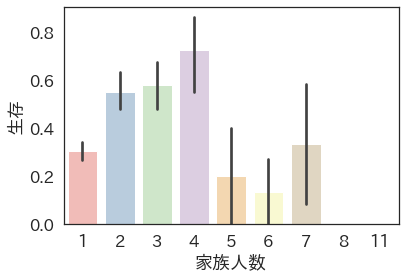

In [128]:
df2['家族人数']=df2['兄弟配偶者数']+df2['両親子供数']+1
sns.barplot(x=df2['家族人数'],y='生存',data=df2)

家族人数別の生存率を確認すると、2~4人家族の生存率。独身と５〜七人家族の生存率が

それぞれ似通っている。そして、家族人数が８人を超えると生存率は０％になる。

それぞれ同一のグループとしてまとめる。

In [129]:
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
# df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
# df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']<8), 'Family_label'] = 1
df.loc[(df['Family']>=8), 'Family_label'] = 0

当初３つのグループに分けて機械学習にかけていたが、

後に条件を緩めて家族人数が８人以上かどうかでグループ分けするとスコアが上昇した。

おそらく、テストデータの家族人数別の生存率が、

実は訓練データとあまり相関していない可能性がある。

### チケット番号から特徴量設定
チケット番号が同じ人が何人いるかで特徴量を設定

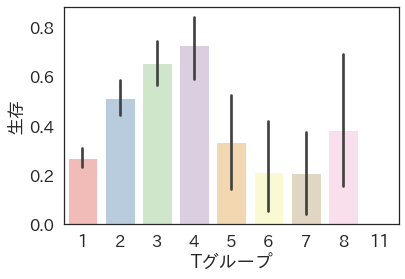

In [130]:
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
Ticket_Count = dict(df2['チケット番号'].value_counts())
df2['Tグループ'] = df2['チケット番号'].map(Ticket_Count)
sns.barplot(x='Tグループ', y='生存', data=df2)
plt.show()

生存率で分けるとチケット番号が同じ人が
* ２〜４人
*１人・５〜８人
*11人以上

のグループに分けられる。

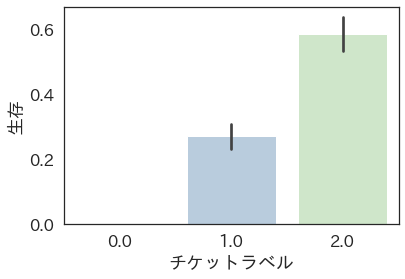

In [131]:
# 生存率で3つにグルーピング
# df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
# df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
# df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
df2.loc[(df2['Tグループ']>=2) & (df2['Tグループ']<=4), 'チケットラベル'] = 2
df2.loc[(df2['Tグループ']>=5) & (df2['Tグループ']<=8) | (df2['Tグループ']==1), 'チケットラベル'] = 1  
df2.loc[(df2['Tグループ']>=11), 'チケットラベル'] = 0
sns.barplot(x='チケットラベル', y='生存', data=df2)
plt.show()

こちらについては当初３グループに分けていたが、後に条件を緩めて５人以上かどうかでグループ分けするとスコアが上昇した。

In [132]:
# 生存率で2つにグルーピング
df.loc[(df['TicketGroup']>=5), 'Ticket_label'] = 1
df.loc[(df['TicketGroup']<5), 'Ticket_label'] = 0

### 部屋番号の欠損値補完
欠損値をunknownに変換。その上で部屋番号の頭文字でグルーピングする。

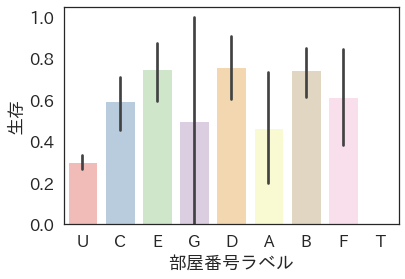

In [133]:
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
df2['部屋番号'] = df2['部屋番号'].fillna('Unknown')
df2['部屋番号ラベル']=df2['部屋番号'].str.get(0)
sns.barplot(x='部屋番号ラベル', y='生存', data=df2)
plt.show()

部屋番号が不明なグループのみ生存率が飛び抜けて低いため、そのまま特徴量として使用する。

### 乗船港の欠損値処理
乗船港の欠損値２件を、一番多い「S」で補完

In [134]:
df['Embarked'] = df['Embarked'].fillna('S') 
print('乗船港の欠損値：',df2['乗船港'].isnull().sum())
df2['乗船港'].value_counts()


乗船港の欠損値： 2


S    914
C    270
Q    123
Name: 乗船港, dtype: int64

## データ前処理
ワンホットエンコーディングを実行し。データを訓練データとテストデータに再度分割。

In [135]:
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','TicketGroup','Cabin_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)
train['Survived'] = train['Survived'].astype('int64')


## モデル構築
pycaretを使用して、モデルの選定

pycaretではXGBoostやCatboostのスコアが高かったが、実際に提出した際、スコアが大きく下がってしまったため過学習している。

いくつかのモデルを提出した結果、最終的に一番スコアが高かったのはランダムフォレストであった。

In [66]:
exp1 = setup(train, target = 'Survived',session_id=4044) #session_idを指定で乱数の固定

Setup Succesfully Completed!


,Description,Value
0,session_id,4044
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(891, 25)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [73]:
compare_models() # モデルの比較

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.8460,0.8705,0.7572,0.8301,0.7902,0.6691,0.6725,1.4175
1,Extreme Gradient Boosting,0.8298,0.8574,0.7446,0.7995,0.7699,0.6353,0.6374,0.0547
2,Gradient Boosting Classifier,0.8267,0.8560,0.7364,0.7982,0.7652,0.6283,0.6304,0.1141
3,Light Gradient Boosting Machine,0.8251,0.8647,0.7446,0.7918,0.7648,0.6260,0.6292,0.0450
4,Extra Trees Classifier,0.8155,0.8559,0.7699,0.7566,0.7617,0.6114,0.6130,0.2534
5,Random Forest Classifier,0.8138,0.8416,0.7362,0.7715,0.7520,0.6032,0.6050,0.1123
6,Decision Tree Classifier,0.8058,0.7855,0.7366,0.7626,0.7435,0.5879,0.5936,0.0066
7,Logistic Regression,0.8026,0.8591,0.7447,0.7441,0.7433,0.5831,0.5843,0.0493
8,Ridge Classifier,0.7930,0.0000,0.7489,0.7268,0.7349,0.5657,0.5688,0.0083
9,Ada Boost Classifier,0.7912,0.8332,0.7324,0.7303,0.7286,0.5596,0.5622,0.0926


In [72]:
rf = create_model('rf') # ランダムフォレストでモデル構築

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8413,0.9252,0.6667,0.8889,0.7619,0.6465,0.6615
1,0.8254,0.8766,0.7083,0.8095,0.7556,0.6207,0.6240
2,0.8254,0.8675,0.7500,0.7826,0.7660,0.6268,0.6272
3,0.8387,0.9292,0.6957,0.8421,0.7619,0.6416,0.6483
4,0.8548,0.9435,0.7500,0.8571,0.8000,0.6869,0.6906
5,0.8226,0.8503,0.7083,0.8095,0.7556,0.6173,0.6207
6,0.8226,0.8914,0.7500,0.7826,0.7660,0.6232,0.6236
7,0.8710,0.9205,0.7500,0.9000,0.8182,0.7195,0.7266
8,0.7742,0.8202,0.7083,0.7083,0.7083,0.5241,0.5241
9,0.8387,0.8613,0.7917,0.7917,0.7917,0.6601,0.6601


In [82]:
# pycaretを使用して提出データの作成する場合
# result = predict_model(rf,data = test)
# PassengerId = test_data['PassengerId']
# predictions = result['Label'].values
# submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
# submission.to_csv("submission.csv", index=False)

In [139]:
from sklearn.ensemble import RandomForestClassifier

X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

# 採用したパラメータ
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=4044, verbose=0,
                       warm_start=True)

model.fit(X_train,y_train)

# 提出データの作成　
PassengerId=test_data['PassengerId']
predictions = model.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)